# Some simple Computer Vision library operations

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
horse = "horse.jpeg"
out = "slider_gray.jpg"
dir = "../dataset/"
result = "../output/"

os.makedirs(os.path.dirname(result), exist_ok=True)

## Grayscale

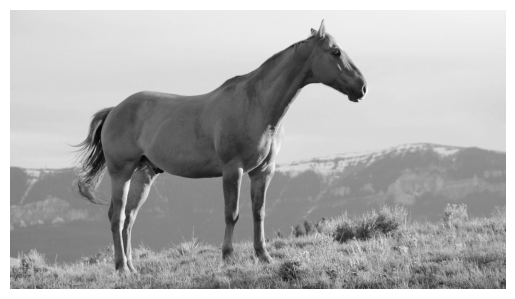

In [3]:
img = cv2.imread(dir + horse)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2.imwrite(result + out, gray)

plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

## Matrix 

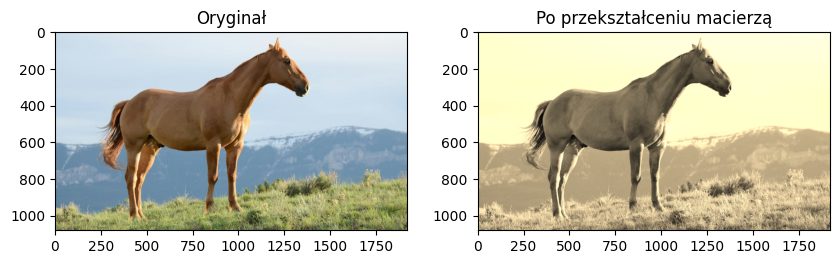

In [4]:
img = cv2.imread(dir + horse)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_float = img.astype(np.float32) / 255.0

trans = np.array([
    [0.393, 0.769, 0.189],
    [0.349, 0.689, 0.168],
    [0.272, 0.534, 0.131]
])

h, w, c = img_float.shape

img_transformed = np.dot(img_float.reshape(-1, 3), trans.T)
img_transformed = np.clip(img_transformed, 0, 1)
img_transformed = img_transformed.reshape(h, w, 3)

# Show
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_float)
plt.title("Oryginał")

plt.subplot(1,2,2)
plt.imshow(img_transformed)
plt.title("Po przekształceniu macierzą")
plt.show()

## Use camera (there is no purpose to this block)

In [5]:
cap = cv2.VideoCapture(0)

while True:
    timer = cv2.getTickCount()
    success, img = cap.read()
    
    fps = cv2.getTickFrequency() / (cv2.getTickCount()-timer)
    cv2.putText(img, str(int(fps)), (20, 20), cv2.FONT_HERSHEY_DUPLEX, 0.7, (65, 45, 10), 1)
    cv2.imshow("Tracking", img)
    
    if cv2.waitKey(1) & 0xff == ord('q') or cv2.getWindowProperty("Tracking", cv2.WND_PROP_VISIBLE) < 1:
        break
    
cv2.destroyAllWindows()
cap.release()

# Using CUDA

### Check for CUDA

In [6]:
import torch

if torch.cuda.is_available():
    print("CUDA available with GPU:", torch.cuda.get_device_name(0))
    print("CUDA runtime:", torch.version.cuda)
    print("Torch:", torch.__version__)

CUDA available with GPU: NVIDIA GeForce RTX 2060
CUDA runtime: 12.1
Torch: 2.5.1+cu121


### Let's give some work to the GPU 

In [7]:
import time

device = "cuda"

# Create large matrices on GPU
x = torch.randn(4096, 4096, device=device)
y = torch.randn(4096, 4096, device=device)

# Measure time for matrix multiplication
t0 = time.time()
z = x @ y
torch.cuda.synchronize()
print("Time:", time.time() - t0)


Time: 0.1726675033569336


### Process image using GPU
Moving the data to the GPU is relatively expensive

— Move data to GPU once, then do as much work as possible there.

In [8]:
import cv2
import numpy as np

img = cv2.imread("../dataset/horse.jpeg", cv2.IMREAD_GRAYSCALE)   # numpy array on CPU
img = cv2.resize(img, (220, 220))                                       # still on CPU

x = torch.from_numpy(img)       # zero copy on CPU RAM - the data is shared between numpy and torch until one of them changes it
x = x.to("cuda") / 255.0        # CPU RAM → GPU VRAM
x = x.float()                   # on GPU :D

# Normalize to [0, 1]
x = x / 255.0

print("Image tensor shape:", x.shape)
print("Device:", x.device)

Image tensor shape: torch.Size([220, 220])
Device: cuda:0
